In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from matplotlib.pyplot import imread
from sklearn.decomposition import PCA
import torch.nn as nn

## Load MNIST data and visualize.

In [2]:
mnist_train, mnist_val = {}, {}
for digit in range(10):
    arr = np.load('data/mnist/{0}.npy'.format(digit))
    num_train = int(0.9 * arr.shape[0])
    mnist_train[digit] = arr[:num_train]
    mnist_val[digit] = arr[num_train:]

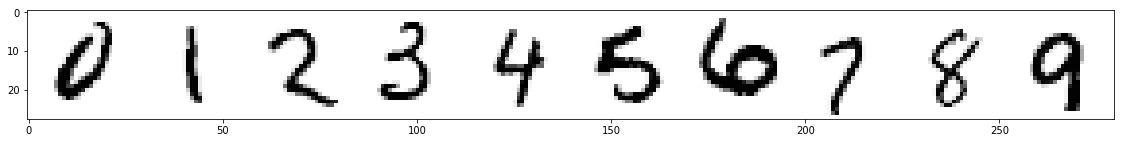

In [3]:
selected_images = []
for digit in mnist_train:
    image_idx = np.random.choice(len(mnist_train[digit]))
    image = mnist_train[digit][image_idx]
    selected_images.append(image)

plt.figure(figsize=(20, 2))
plt.imshow(np.concatenate(selected_images, axis=1), cmap='Greys')
plt.show()

## Perform PCA on MNIST onto two components.

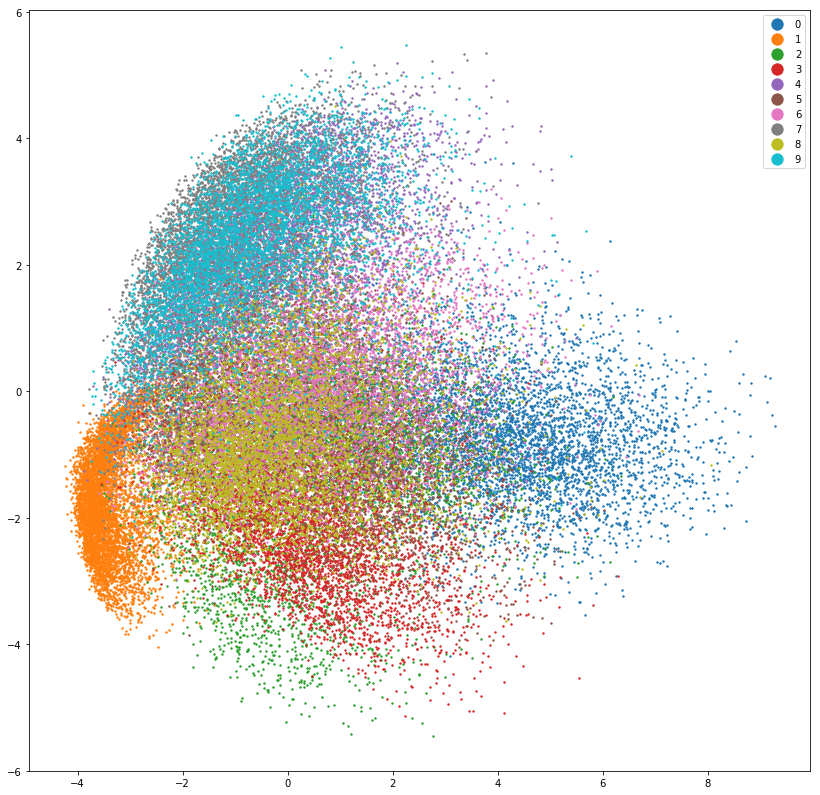

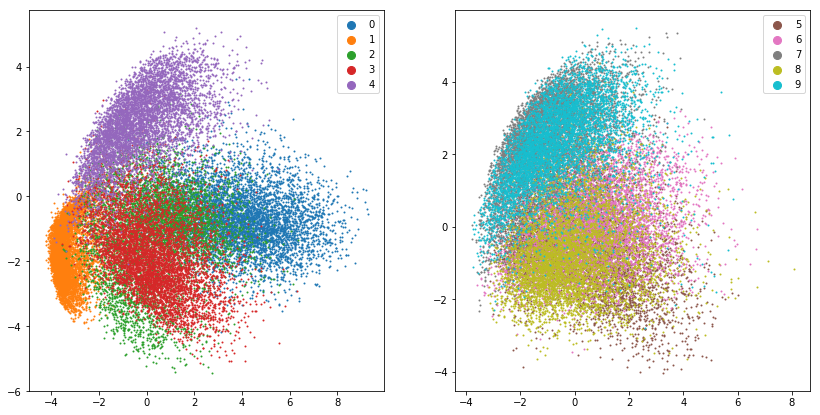

In [4]:
X = np.concatenate([mnist_train[digit].reshape(-1, 28 ** 2) for digit in mnist_train], axis=0)

pca = PCA(n_components=2)
pca.fit(X)

plt.figure(figsize=(14, 14))
for digit in mnist_train:
    transformed = pca.transform(mnist_train[digit].reshape(-1, 28 ** 2))
    plt.scatter(transformed[:, 0], transformed[:, 1], s=2, label=digit)

plt.legend(markerscale=8)
plt.show()


colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig, ax = plt.subplots(1, 2, figsize=(14, 7))
for digit in range(5):
    transformed = pca.transform(mnist_train[digit].reshape(-1, 28 ** 2))
    ax[0].scatter(transformed[:, 0], transformed[:, 1], s=1, label=digit, c=colors[digit])
for digit in range(5, 10):
    transformed = pca.transform(mnist_train[digit].reshape(-1, 28 ** 2))
    ax[1].scatter(transformed[:, 0], transformed[:, 1], s=1, label=digit, c=colors[digit])
    
ax[0].legend(markerscale=8)
ax[1].legend(markerscale=8)
plt.show()

We see that individual clusters of data are visible when we use PCA! That means that important information about the data is preserved when we compress using PCA. However, some of the clusters overlap, such as the '8' and '3' clusters. Let's do better with autoencoders.

## Create our autoencoder with PyTorch.

First, we'll define the structure of our autoencoder.

In [5]:
class Autoencoder(nn.Module):
    
    def __init__(self, sizes):
        
        super().__init__()
        
        encoder_layers = []
        for inp, out in zip(sizes[:-2], sizes[1:-1]):
            encoder_layers.append(nn.Linear(inp, out))
            encoder_layers.append(nn.ReLU())
        encoder_layers.append(nn.Linear(sizes[-2], sizes[-1]))
            
        self.encoder = nn.Sequential(*encoder_layers)
        
        
        decoder_layers = []
        for inp, out in zip(sizes[::-1][:-2], sizes[::-1][1:-1]):
            decoder_layers.append(nn.Linear(inp, out))
            decoder_layers.append(nn.ReLU())
        decoder_layers.append(nn.Linear(sizes[::-1][-2], sizes[::-1][-1]))
        decoder_layers.append(nn.Sigmoid())
            
        self.decoder = nn.Sequential(*decoder_layers)
            
    def forward(self, inp):
        return self.decoder(self.encoder(inp))


Now, we'll create and train our autoencoder on MNIST with stochastic gradient descent.

In [7]:
model = Autoencoder([
    28 ** 2,
    512,
    128,
    2
])
print(model)

optimizer = torch.optim.Adam(model.parameters())

X_train = np.concatenate([mnist_train[digit].reshape(-1, 28 ** 2) for digit in mnist_train], axis=0)
X_train = torch.from_numpy(X_train)
np.random.shuffle(X_train)

X_val = np.concatenate([mnist_val[digit].reshape(-1, 28 ** 2) for digit in mnist_val], axis=0)
X_val = torch.from_numpy(X_val)
np.random.shuffle(X_val)

batch_size = 128

for epoch in range(10):
    for i in range(len(X_train) // batch_size):
        
        inp = X_train[batch_size * i : batch_size * i + batch_size]
        output = model(inp)
        train_loss = torch.mean((inp - output) ** 2)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
    
    train_loss = torch.mean((X_train - model(X_train)) ** 2).item()
    validation_loss = torch.mean((X_val - model(X_val)) ** 2).item()
    print("Epoch {0}: Train loss = {1}, validation loss = {2}".format(epoch, train_loss, validation_loss))
        
    

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
    (5): Sigmoid()
  )
)
Epoch 0: Train loss = 0.043097104877233505, validation loss = 0.043460652232170105
Epoch 1: Train loss = 0.04011942073702812, validation loss = 0.040752626955509186
Epoch 2: Train loss = 0.03850018233060837, validation loss = 0.039197687059640884
Epoch 3: Train loss = 0.03727496415376663, validation loss = 0.03809672221541405
Epoch 4: Train loss = 0.03646770492196083, validation loss = 0.03738603740930557
Epoch 5: Train loss = 0.03573782742023468, validation loss = 0.0367

Let's visualize the compression that the autoencoder has learned.

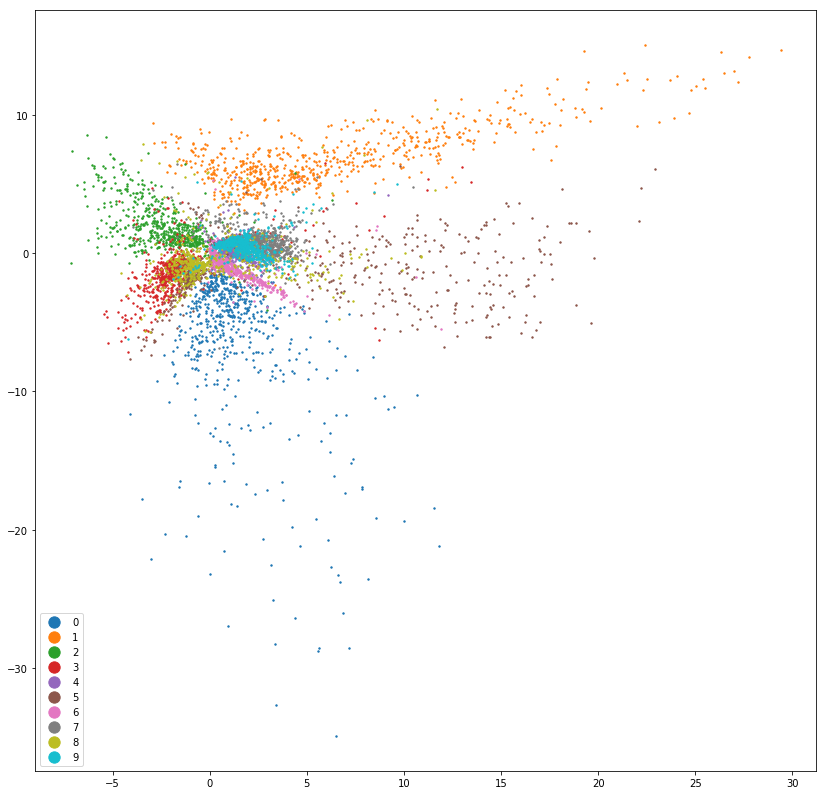

In [8]:
plt.figure(figsize=(14, 14))
for digit in mnist_val:
    inp = torch.tensor(mnist_val[digit].reshape(-1, 28 ** 2))
    transformed = model.encoder(inp).detach().numpy()
    plt.scatter(transformed[:, 0], transformed[:, 1], s=2, label=digit)

plt.legend(markerscale=8)
plt.show()